In [1]:
# Import libraries and dependencies
from pathlib import Path
import pandas as pd
import plotly.express as px
import numpy as np
import hvplot.pandas
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#### THE TOP HALF OF THIS NOTEBOOK WILL BE CODE COPIED FROM THE CPI HPI AND MIGRATION NOTEBOOKS ####
#### THE NEW CODE SECTION IS LABELLED BELOW ####

In [3]:
# CPI SECTION
# Read in CSVs
tx_csv = Path('Resources/economic_indicators.csv')
tx_US_df = pd.read_csv(tx_csv)
fl_csv = Path('Resources/florida_cpi.csv')
fl_cpi_df = pd.read_csv(fl_csv, header=None)
cacsv = Path('Resources/ca_cpi.csv')
ca_cpi_df = pd.read_csv(cacsv)

In [4]:
# TEXAS SECTION
# Drop columns
tx_US_df = tx_US_df.drop(columns=['Consumer Confidence West South Central', 'PCE Deflator', 
                              'CPI U.S. Ex Food and Energy', 'Nonfarm Employment TX', 'Nonfarm Employment Florida',
                              'Nonfarm Employment New York', 'Nonfarm Employment Texas', 'Nonfarm Employment California',
                              'Gross Value Crude Oil Production', 'Gross Value Natural Gas Production', 
                              'Motor Fuel Taxed Gasoline', 'Motor Fuel Taxed Diesel'])

# Drop more columns
tx_US_df = tx_US_df.drop(columns=['Nonfarm Employment U.S.', 'Unemployment TX', 'Unemployment U.S.', 
                              'Single Family Building Permits TX', 'Multi Family Building Permits TX',
                              'Non Residential Building Construction', 'Total Sales Tax Collections Retail TX',
                              'Total Sales Tax Collections TX', 'Total Sales Tax Collections TX',
                              'Retail Gasoline Price TX', 'Retail Diesel Price TX', 'Nonfarm Employment Illinois'])

# Remove nulls
tx_US_df = tx_US_df.dropna().copy()
tx_US_df.isnull().sum()

# Calculate average CPI by year for Texas and USA
tx_cpi_by_year = tx_US_df.groupby('Year')['Consumer Price Index TX'].mean()
tx_cpi_by_year.columns = ['Year', 'TX CPI']
us_cpi_by_year = tx_US_df.groupby('Year')['Consumer Price Index U.S.'].mean()
us_cpi_by_year.columns = ['Year', 'US CPI']

# Reset index to convert indices to column names and add 'TX CPI' column
tx_cpi_by_year = tx_cpi_by_year.reset_index(name='TX CPI')
us_cpi_by_year = us_cpi_by_year.reset_index(name='US CPI')

# Concat Texas CPI and US CPI dfs into new tx_US_cpi df
tx_US_cpi = pd.concat([tx_cpi_by_year, us_cpi_by_year], axis='columns', join='inner')
tx_US_cpi

# Drop redundant year column
tx_US_cpi.columns = ['Year','TX CPI','Year duplicate','US CPI']
tx_US_cpi = tx_US_cpi.drop(columns=['Year duplicate'])

# Calculate inflation as pct_change of TX and US CPIs
tx_US_cpi['TX Inflation'] = tx_US_cpi['TX CPI'].pct_change()
tx_US_cpi['TX Inflation'] = tx_US_cpi['TX Inflation'] * 100
tx_US_cpi['US Inflation'] = tx_US_cpi['US CPI'].pct_change()
tx_US_cpi['US Inflation'] = tx_US_cpi['US Inflation'] * 100

# Drop nulls
tx_US_cpi = tx_US_cpi.dropna().copy()

# Drop columns
tx_inflation = tx_US_cpi.drop(columns=['TX CPI', 'US CPI', 'US Inflation', 'Year'])

# Create new df for US inflation
us_inflation = tx_US_cpi[['US Inflation']]

In [5]:
# FLORIDA SECTION
# Add column names
column_names = ['Year','Jan','Feb','Mar','Apr','May','June','Jul','Aug','Sep','Oct','Nov','Dec']
fl_cpi_df.columns = column_names
fl_cpi_df

# Calculate average cpi per year by .mean of each row
fl_cpi_df['Annual'] = fl_cpi_df.loc[:, 'Jan':'Dec'].mean(axis=1)

# Drop month columns
fl_cpi_df = fl_cpi_df.drop(columns=['Jan','Feb','Mar','Apr','May','June','Jul','Aug','Sep','Oct','Nov','Dec'])

# Calculate new FL Inflation column as pct_change * 100
fl_cpi_df['FL Inflation'] = fl_cpi_df['Annual'].pct_change()
fl_cpi_df['FL Inflation'] = fl_cpi_df['FL Inflation'] * 100

fl_inflation = fl_cpi_df.drop(columns=['Annual', 'Year'])

# CALIFORNIA SECTION
# Drop columns
ca_cpi_df = ca_cpi_df.drop(columns=['CONSUMER PRICE INDICES, UNITED STATES AND CALIFORNIA', 
                                    'CPI-U\n(All Urban Consumers)\n\nUnited States\n% Change',
                                    'CPI-U\n(All Urban Consumers)\n\nCalifornia\nIndex',
                                    'CPI-U\n(All Urban Consumers)\n\nCalifornia\n% Change',
                                    'CPI-W \n(Urban Wage Earners & Clerical Workers)\n\nUnited States\nIndex',
                                    'CPI-W \n(Urban Wage Earners & Clerical Workers)\n\nUnited States\n% Change',
                                    'CPI-W \n(Urban Wage Earners & Clerical Workers)\n\nCalifornia\n% Change'])

# Rename Column
ca_cpi_df = ca_cpi_df.rename(columns={'CPI-W \n(Urban Wage Earners & Clerical Workers)\n\nCalifornia\nIndex': 'CA CPI'})

# Convert year column to int and select relevant timeframe
ca_cpi_df['Year'] = ca_cpi_df['Year'].astype(int)
ca_cpi_df = ca_cpi_df[(ca_cpi_df['Year'] >= 2012) & (ca_cpi_df['Year'] <= 2023)]
ca_cpi_df = ca_cpi_df.reset_index(drop=True)

# Calculate CA Inflation as pct_change of CPI * 100
ca_cpi_df['CA Inflation'] = ca_cpi_df['CA CPI'].pct_change()
ca_cpi_df['CA Inflation'] = ca_cpi_df['CA Inflation'] * 100

ca_inflation = ca_cpi_df.drop(columns=['CA CPI', 'Year'])

In [6]:
# MIGRATION SECTION
# Read in csvs
csv_files = ['Resources/state_to_state_mig_2012.csv', 'Resources/state_to_state_mig_2013.csv',
             'Resources/state_to_state_mig_2014.csv', 'Resources/state_to_state_mig_2015.csv',
             'Resources/state_to_state_mig_2016.csv', 'Resources/state_to_state_mig_2017.csv',
             'Resources/state_to_state_mig_2018.csv', 'Resources/state_to_state_mig_2019.csv',
             'Resources/state_to_state_mig_2021.csv','Resources/state_to_state_mig_2022.csv'
            ]
# Organize csv files into mig_dfs list
mig_dfs = []
for file in csv_files:
    csv_path = Path(file)
    df = pd.read_csv(csv_path)
    mig_dfs.append(df)
# concat list into master migration dataframe
mm = pd.concat(mig_dfs)

# Create dictionary with state names and abbreviations
state_abbreviations = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
    'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO',
    'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
    'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH',
    'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT',
    'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}

# Use state abbreviations dict to replace full state names with abbreviations
mm['current_state'] = mm['current_state'].replace(state_abbreviations)
mm['prev_state'] = mm['prev_state'].replace(state_abbreviations)

# drop nulls
mm = mm.dropna().copy()
mm.isnull().sum()

# rename columns
mm = mm.rename(columns={'current_state': 'state', 'migration_year': 'year'})

# sum the immigration for each state and year by grouping by 'year' and 'state'
mm_immigration = mm.groupby(['year', 'state'])['migration'].sum()
mm_immigration.columns = ['year','state', 'total_immigration']

# Reset index to convert indices to column names and add 'total_immigration' column
mm_immigration_df = mm_immigration.reset_index(name='total_immigration')

# sum the emmigration for each state and each year by grouping by 'year' and 'prev_state'
mm_emigration = mm.groupby(['year', 'prev_state'])['migration'].sum()
mm_emigration.columns = ['year','state', 'total_emigration']

# Reset index to convert indices to column names and add 'total_emigration' column
mm_emigration_df = mm_emigration.reset_index(name='total_emigration')

# Concat immigration and emigration dfs into new mm_totals df
mm_totals = pd.concat([mm_immigration_df, mm_emigration_df], axis='columns', join='inner')

# Drop redundant 'year' column and unneccesary 'prev_state' column
mm_totals = mm_totals.drop(columns=['prev_state'])
mm_totals.columns = ['year','state','total_immigration','year_duplicate','total_emigration']
mm_totals = mm_totals.drop(columns=['year_duplicate'])

# Calculate 'net_migration'
mm_totals['net_migration'] = mm_totals['total_immigration'] - mm_totals['total_emigration']

In [7]:
# HPI SECTION
# Read in CSVs
csv_path = Path("Resources/HPI_PO_state.csv")
df_HPI_state = pd.read_csv(csv_path)

# Drop null values from dataframe
df_HPI_state.dropna(inplace=True)

# Strip whitespace from "state" column
df_HPI_state['state'] = df_HPI_state['state'].str.strip()

# Drop decimals in 'yr' and 'qtr' columns by converting to integer
df_HPI_state['yr'] = df_HPI_state['yr'].astype(int)
df_HPI_state['qtr'] = df_HPI_state['qtr'].astype(int)

# Checking datagframe for nulls
df_HPI_state.isnull().sum()

# Set list of removal values
removal_yrs = [1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
               2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
               2010]

removal_qtrs = [1, 2, 3]

# Drop years outside of study period of 2012-2022
df_HPI_state.drop(df_HPI_state[df_HPI_state['yr'].isin(removal_yrs)].index, inplace=True)

# Drop quarter 1, 2, and 3, rows and retain quarter 4 values
df_HPI_state.drop(df_HPI_state[df_HPI_state['qtr'].isin(removal_qtrs)].index, inplace=True)
df_HPI_state.reset_index(drop=True, inplace=True)

# Drop 'qtr' column and 'index_sa' column
df_HPI_state.drop(columns=['qtr', 'index_nsa'], inplace=True)

# Convert 'yr' to datetime as 'year' and drop 'yr' column
df_HPI_state['year'] = pd.to_datetime(df_HPI_state['yr'], format='%Y').dt.year
df_HPI_state.drop(columns=['yr'], inplace=True)

# Reset index
df_HPI_state.reset_index(drop=True, inplace=True)

# Set the dataframe index to 'year' and 'state'
df_HPI_state = df_HPI_state.set_index(['year','state'])

# Reset the dataframe index
df_HPI_reset = df_HPI_state.reset_index()

# Calculate the difference in percentage HPI growth from year-to-year
df_HPI_reset['pct_appreciation'] = df_HPI_reset.groupby('state')['index_sa'].diff()

# drop null values from dataframe
df_HPI_reset.dropna(inplace=True)
df_HPI_reset

,year,state,index_sa,pct_appreciation
1,2012,AK,225.65,3.42
2,2013,AK,230.68,5.03
3,2014,AK,239.16,8.48
4,2015,AK,245.07,5.91
5,2016,AK,247.14,2.07
...,...,...,...,...
607,2018,WY,337.78,11.22
608,2019,WY,360.04,22.26
609,2020,WY,389.91,29.87
610,2021,WY,454.76,64.85


In [8]:
#### NEW CODE SECTION ####

In [9]:
# INFLATION
# Combine inflation dfs
cpi_combined_df = pd.concat([ca_inflation, fl_inflation, tx_inflation, us_inflation], axis='columns', join='inner')
cpi_combined_df

,CA Inflation,FL Inflation,TX Inflation,US Inflation
1,1.440784,1.585267,1.616461,1.190971
2,1.708045,-0.727439,1.991887,1.622223
3,1.111902,0.837871,-0.300528,0.118627
4,1.894320,2.049456,1.502445,1.261583
5,2.872938,2.299483,2.294962,2.130110
6,3.878910,1.293125,2.667512,2.442583
7,2.946129,0.879083,1.693439,1.812210
8,1.767820,5.513724,0.326549,1.210115
9,4.745492,8.916966,4.852965,4.722137
10,7.747913,4.148647,8.520520,8.002800


In [10]:
# MIGRATION
# Assign CA mig data to new df
ca_net_mig = mm_totals[mm_totals['state'] == 'CA']
ca_net_mig

,year,state,total_immigration,total_emigration,net_migration
4,2012,CA,493641.0,566986.0,-73345.0
55,2013,CA,485477.0,581679.0,-96202.0
106,2014,CA,513968.0,593308.0,-79340.0
157,2015,CA,514477.0,643710.0,-129233.0
208,2016,CA,514758.0,657690.0,-142932.0
259,2017,CA,523131.0,661026.0,-137895.0
310,2018,CA,501023.0,691145.0,-190122.0
361,2019,CA,480204.0,653551.0,-173347.0
412,2021,CA,433402.0,841065.0,-407663.0
463,2022,CA,475803.0,817669.0,-341866.0


In [11]:
# Drop all other columns except "net_migration"
ca_net_mig = ca_net_mig.drop(columns=['year', 'state', 'total_immigration', 'total_emigration'])

# Reset new df index
ca_net = ca_net_mig.reset_index(drop=True)
# Rename to include state label
ca_net = ca_net.rename(columns={'net_migration': 'CA Net Migration'})
ca_net

,CA Net Migration
0,-73345.0
1,-96202.0
2,-79340.0
3,-129233.0
4,-142932.0
5,-137895.0
6,-190122.0
7,-173347.0
8,-407663.0
9,-341866.0


In [12]:
# Assign FL data to new FL df
fl_net_mig = mm_totals[mm_totals['state'] == 'FL']

# Drop all other columns except "net_migration"
fl_net_mig = fl_net_mig.drop(columns=['year', 'state', 'total_immigration', 'total_emigration'])

# Reset index
fl_net = fl_net_mig.reset_index(drop=True)

# Rename column to include state label
fl_net = fl_net.rename(columns={'net_migration': 'FL Net Migration'})
fl_net

,FL Net Migration
0,108823.0
1,105411.0
2,108985.0
3,139618.0
4,171566.0
5,118890.0
6,116284.0
7,144310.0
8,205163.0
9,249064.0


In [13]:
# Same for Texas
tx_net_mig = mm_totals[mm_totals['state'] == 'TX']
tx_net_mig = tx_net_mig.drop(columns=['year', 'state', 'total_immigration', 'total_emigration'])
tx_net = tx_net_mig.reset_index(drop=True)
tx_net = tx_net.rename(columns={'net_migration': 'TX Net Migration'})
tx_net

,TX Net Migration
0,105565.0
1,138057.0
2,103465.0
3,107689.0
4,87656.0
5,57173.0
6,101805.0
7,106646.0
8,144032.0
9,174261.0


In [14]:
# HPI SECTION
# Assign all FL data to new df
fl_hpi = df_HPI_reset[df_HPI_reset['state'] == 'FL']
# Drop all columns except "pct_appreciation"
fl_hpi = fl_hpi.drop(columns=['year', 'state', 'index_sa'])
# Reset Index
fl_hpi = fl_hpi.reset_index(drop=True)
# Change column name to include state label
fl_hpi = fl_hpi.rename(columns={'pct_appreciation': 'FL Home Appreciation'})
fl_hpi

,FL Home Appreciation
0,14.51
1,22.30
2,14.48
3,20.87
4,22.81
5,21.09
6,20.04
7,19.35
8,38.54
9,94.17


In [15]:
# Same for Texas
tx_hpi = df_HPI_reset[df_HPI_reset['state'] == 'TX']
tx_hpi = tx_hpi.drop(columns=['year', 'state', 'index_sa'])
tx_hpi = tx_hpi.reset_index(drop=True)
tx_hpi = tx_hpi.rename(columns={'pct_appreciation': 'TX Home Appreciation'})
tx_hpi

,TX Home Appreciation
0,10.79
1,13.34
2,13.65
3,14.91
4,15.88
5,18.18
6,13.62
7,14.06
8,27.69
9,63.89


In [16]:
# Same for California
ca_hpi = df_HPI_reset[df_HPI_reset['state'] == 'CA']
ca_hpi = ca_hpi.drop(columns=['year', 'state', 'index_sa'])
ca_hpi = ca_hpi.reset_index(drop=True)
ca_hpi = ca_hpi.rename(columns={'pct_appreciation': 'CA Home Appreciation'})
ca_hpi

,CA Home Appreciation
0,17.32
1,30.74
2,14.94
3,15.54
4,15.94
5,19.75
6,13.09
7,12.60
8,34.37
9,63.97


In [17]:
# Concat all dfs
corr_df = pd.concat([cpi_combined_df, tx_net, fl_net, ca_net, ca_hpi, tx_hpi, fl_hpi], axis='columns', join='inner')
corr_df.head()

,CA Inflation,FL Inflation,TX Inflation,US Inflation,TX Net Migration,FL Net Migration,CA Net Migration,CA Home Appreciation,TX Home Appreciation,FL Home Appreciation
1,1.440784,1.585267,1.616461,1.190971,138057.0,105411.0,-96202.0,30.74,13.34,22.30
2,1.708045,-0.727439,1.991887,1.622223,103465.0,108985.0,-79340.0,14.94,13.65,14.48
3,1.111902,0.837871,-0.300528,0.118627,107689.0,139618.0,-129233.0,15.54,14.91,20.87
4,1.894320,2.049456,1.502445,1.261583,87656.0,171566.0,-142932.0,15.94,15.88,22.81
5,2.872938,2.299483,2.294962,2.130110,57173.0,118890.0,-137895.0,19.75,18.18,21.09


Text(0.5, 1.0, 'All States and all Variables Correlation Heatmap')

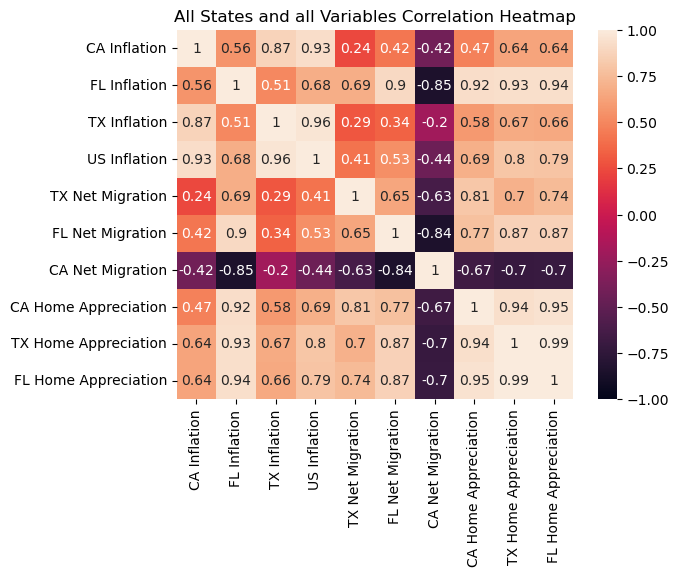

In [18]:
# Calculate Correlation
corr = corr_df.corr()
# Plot correlation
sns.heatmap(corr, vmin=-1, vmax=1, annot=True,)
plt.title('All States and all Variables Correlation Heatmap')

In [19]:
# Intra State Correlations
# Grab all CA columns and assign to state specific df
ca_totals = corr_df[['CA Inflation', 'CA Net Migration', 'CA Home Appreciation']]
ca_totals

,CA Inflation,CA Net Migration,CA Home Appreciation
1,1.440784,-96202.0,30.74
2,1.708045,-79340.0,14.94
3,1.111902,-129233.0,15.54
4,1.894320,-142932.0,15.94
5,2.872938,-137895.0,19.75
6,3.878910,-190122.0,13.09
7,2.946129,-173347.0,12.60
8,1.767820,-407663.0,34.37
9,4.745492,-341866.0,63.97


Text(0.5, 1.0, 'California Correlation Heatmap')

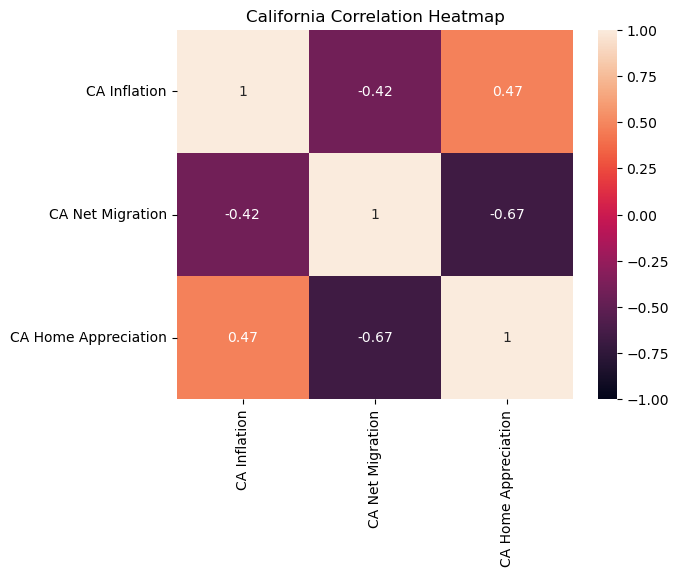

In [20]:
# Calculate correlation
ca_corr = ca_totals.corr()
# Plot correlation
sns.heatmap(ca_corr, vmin=-1, vmax=1, annot=True)
plt.title('California Correlation Heatmap')

Text(0.5, 1.0, 'Florida Correlation Heatmap')

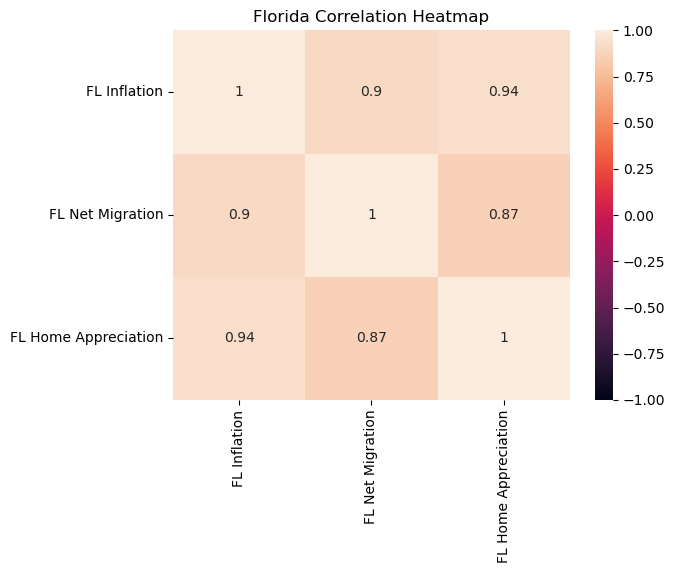

In [21]:
# Same for Florida
fl_totals = corr_df[['FL Inflation', 'FL Net Migration', 'FL Home Appreciation']]
fl_corr = fl_totals.corr()
sns.heatmap(fl_corr, vmin=-1, vmax=1, annot=True)
plt.title('Florida Correlation Heatmap')

Text(0.5, 1.0, 'Texas Correlation Heatmap')

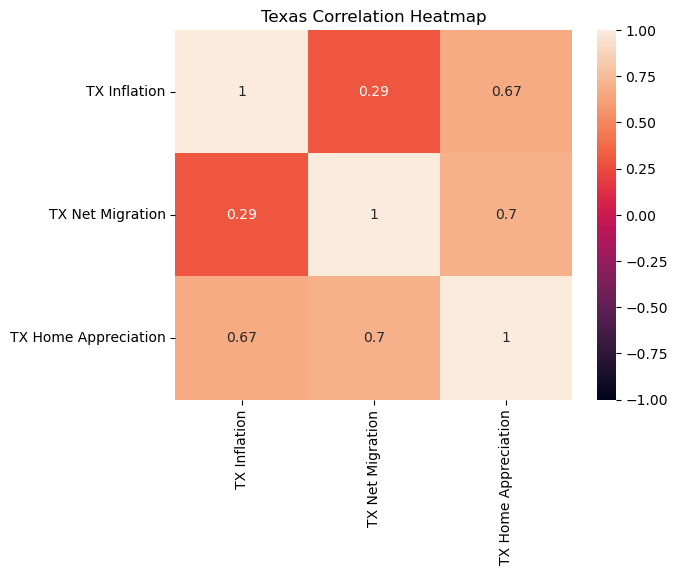

In [22]:
# Same for Texas
tx_totals = corr_df[['TX Inflation', 'TX Net Migration', 'TX Home Appreciation']]
tx_corr = tx_totals.corr()
sns.heatmap(tx_corr, vmin=-1, vmax=1, annot=True)
plt.title('Texas Correlation Heatmap')